In [1]:
!pip install timm
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import os
from glob import glob
import random
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms.functional import InterpolationMode

## 이미지 압축 해제

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
directory_path = '/content/SceneImages'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

%cd $directory_path
!unzip -qq '/content/drive/MyDrive/ML_Project3/SceneImages.zip'

/content/SceneImages


In [5]:
file_path = list(glob('/content/SceneImages/*.jpg'))
len(file_path)

4225

In [6]:
#Hyperparameters

EPOCH = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [7]:
train_path = '/content/drive/MyDrive/ML_Project3/train.csv'
test_path = '/content/drive/MyDrive/ML_Project3/test.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [8]:
def get_assets(model, instance):
    LEARNING_RATE = 0.001
    EPOCH = 10
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    scheduler_mapping = {
        0: lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2),
        1: lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, cooldown=0),
        2: lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    }

    scheduler = scheduler_mapping[instance]

    return criterion, optimizer, scheduler

In [9]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

In [19]:
def get_model(instance):
    model_name_mapping = {
        0: 'vit_base_patch16_224',
        1: 'swinv2_base_window8_256',
        2: 'caformer_m36'
    }

    model_name = model_name_mapping[instance]
    model = timm.create_model(model_name, pretrained=True)

    model = freeze_model(model)

    if instance == 0:
        model.head = nn.Linear(model.head.in_features, 6, bias=True)
    elif instance == 1:
        model.head.fc = nn.Linear(model.head.fc.in_features, 6, bias=True)
    elif instance == 2:
        for name, module in model.named_modules():
            if isinstance(module, nn.Linear) and module.out_features == 1000:
                in_features = module.in_features
                new_linear = nn.Linear(in_features, 6, bias=True)
                if name == 'head.fc':
                    model.head.fc = new_linear
                else:
                    parent_module = dict(model.named_modules())[name.rsplit('.', 1)[0]]
                    parent_module.add_module(name.rsplit('.', 1)[-1], new_linear)

    return model

In [23]:
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        img = np.array(img)
        augmented = self.transform(image=img)
        return augmented['image']


def get_transform(instance):
    resolution_mapping = {
        0: 224,
        1: 256,
        2: 224
    }

    resolution = resolution_mapping[instance]

    albumentations_transform = A.Compose([
        A.Resize(width=resolution, height=resolution, interpolation=3),
        A.CenterCrop(width = resolution, height= resolution),
        A.GaussNoise(p=0.5, var_limit=(0.025, 0.025)),
        A.HueSaturationValue(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    train_transform = transforms.Compose([
        AlbumentationsTransform(albumentations_transform)
    ])

    test_transform = transforms.Compose([
        transforms.Resize((resolution, resolution), interpolation=transforms.functional.InterpolationMode('bicubic')),
        transforms.ToTensor(),
        transforms.Normalize(mean=([0.485, 0.456, 0.406]), std=([0.229, 0.224, 0.225])),
    ])

    return train_transform, test_transform

## Dataset Preparation

In [12]:
class ImageDataset(Dataset):
    def __init__(self, labels, img_dir, img_list, transform):
        if labels is not None:
            self.img_labels = np.array(labels)
        else:
            self.img_labels = None
        self.img_dir = img_dir
        self.img_paths = np.array([os.path.join(self.img_dir, img_name) for img_name in img_list])
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        if self.img_labels is not None:
            label = self.img_labels[idx]
            return image, label
        return image

In [13]:
def get_all_settings(instance):
    model = get_model(instance)
    criterion, optimizer, scheduler = get_assets(model, instance)
    train_transform, test_transform = get_transform(instance)

    train_set = pd.read_csv(train_path)
    test_set = pd.read_csv(test_path)
    train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42, stratify=train_set.label)

    # Create submission dataset and dataloader
    train_dataset = ImageDataset(
        labels = train_set['label'],
        img_dir='/content/SceneImages',
        img_list=train_set['image_name'],
        transform=train_transform
    )

    val_dataset = ImageDataset(
        labels = val_set['label'],
        img_dir='/content/SceneImages',
        img_list=val_set['image_name'],
        transform=test_transform
    )

    test_dataset = ImageDataset(
        labels = None,
        img_dir='/content/SceneImages',
        img_list=test_set['image_name'],
        transform=test_transform
    )

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader

## 검증 훈련 루프

In [14]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [15]:
def train_model(model, criterion, scheduler, optimizer, train_dataloader, val_dataloader, test_dataloader):
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    with tqdm(total=((len(train_dataloader) + len(val_dataloader)) * EPOCH + len(val_dataloader) + len(test_dataloader)), desc='Fine-tuning') as pbar:
        for epoch in range(EPOCH):
            model.train()
            train_loss = 0.0
            correct_train = 0

            for images, labels in train_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * images.size(0)

                # Train accuracy
                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                pbar.update(1)

            train_loss = train_loss / len(train_dataloader.dataset)
            train_accuracy = correct_train / len(train_dataloader.dataset)

            model.eval()
            val_loss = 0.0
            correct_val = 0

            with torch.no_grad():
                for images, labels in val_dataloader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)

                    # Validation accuracy
                    _, preds = torch.max(outputs, 1)
                    correct_val += (preds == labels).sum().item()
                    pbar.update(1)

            val_loss = val_loss / len(val_dataloader.dataset)
            val_accuracy = correct_val / len(val_dataloader.dataset)

            print(f" Epoch {epoch+1}/{EPOCH}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

            try:
                scheduler.step()
            except TypeError:
                scheduler.step(val_loss)

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)
            train_accuracy_history.append(train_accuracy)
            val_accuracy_history.append(val_accuracy)

        val_logits = []
        model.eval()
        with torch.no_grad():
            for inputs, _ in val_dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                val_logits.append(outputs.cpu())
                pbar.update(1)

        val_logits = torch.cat(val_logits, dim=0)


        test_logits = []
        model.eval()
        with torch.no_grad():
            for inputs in test_dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                test_logits.append(outputs.cpu())
                pbar.update(1)

        test_logits = torch.cat(test_logits, dim=0)

        return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history, val_logits, test_logits

In [24]:
seed_everything()

results_infos = {
    0 : {'model_name': 'ViT-B'},
    1 : {'model_name': 'Swinv2-B'},
    2 : {'model_name': 'CAFormer-M36'}
}

for instance in range(3):
    print(f"Model: {results_infos[instance]['model_name']}")
    model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader = get_all_settings(instance)

    model = model.to(device)

    train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history, val_logits, test_logits = train_model(model, criterion, scheduler, optimizer, train_dataloader, val_dataloader, test_dataloader)

    results_infos[instance]['train_loss_history'] = train_loss_history
    results_infos[instance]['val_loss_history'] = val_loss_history
    results_infos[instance]['train_accuracy_history'] = train_accuracy_history
    results_infos[instance]['val_accuracy_history'] = val_accuracy_history
    results_infos[instance]['val_logits'] = val_logits
    results_infos[instance]['test_logits'] = test_logits

    model = model.cpu()
    print('\n')

Model: ViT-B


Fine-tuning:  10%|▉         | 60/619 [00:33<03:59,  2.33it/s]

 Epoch 1/10: Train Loss: 0.4913, Val Loss: 0.2576, Train Acc: 0.8306, Val Acc: 0.9049


Fine-tuning:  19%|█▉        | 120/619 [01:06<03:29,  2.38it/s]

 Epoch 2/10: Train Loss: 0.2108, Val Loss: 0.2402, Train Acc: 0.9283, Val Acc: 0.9141


Fine-tuning:  29%|██▉       | 180/619 [01:39<03:10,  2.31it/s]

 Epoch 3/10: Train Loss: 0.1825, Val Loss: 0.2276, Train Acc: 0.9369, Val Acc: 0.9207


Fine-tuning:  39%|███▉      | 240/619 [02:12<02:46,  2.28it/s]

 Epoch 4/10: Train Loss: 0.1674, Val Loss: 0.2280, Train Acc: 0.9396, Val Acc: 0.9207


Fine-tuning:  48%|████▊     | 300/619 [02:46<02:23,  2.23it/s]

 Epoch 5/10: Train Loss: 0.1568, Val Loss: 0.2262, Train Acc: 0.9458, Val Acc: 0.9221


Fine-tuning:  58%|█████▊    | 360/619 [03:19<01:52,  2.30it/s]

 Epoch 6/10: Train Loss: 0.1603, Val Loss: 0.2442, Train Acc: 0.9435, Val Acc: 0.9128


Fine-tuning:  68%|██████▊   | 420/619 [03:53<01:24,  2.35it/s]

 Epoch 7/10: Train Loss: 0.1508, Val Loss: 0.2329, Train Acc: 0.9462, Val Acc: 0.9128


Fine-tuning:  78%|███████▊  | 480/619 [04:26<00:59,  2.33it/s]

 Epoch 8/10: Train Loss: 0.1355, Val Loss: 0.2281, Train Acc: 0.9518, Val Acc: 0.9155


Fine-tuning:  87%|████████▋ | 540/619 [04:59<00:33,  2.37it/s]

 Epoch 9/10: Train Loss: 0.1236, Val Loss: 0.2203, Train Acc: 0.9600, Val Acc: 0.9260


Fine-tuning:  97%|█████████▋| 600/619 [05:33<00:08,  2.33it/s]

 Epoch 10/10: Train Loss: 0.1189, Val Loss: 0.2167, Train Acc: 0.9561, Val Acc: 0.9300


Fine-tuning: 100%|██████████| 619/619 [05:41<00:00,  1.81it/s]




Model: Swinv2-B


Fine-tuning:  10%|▉         | 60/619 [00:53<06:49,  1.37it/s]

 Epoch 1/10: Train Loss: 0.6814, Val Loss: 0.3995, Train Acc: 0.8127, Val Acc: 0.8732


Fine-tuning:  19%|█▉        | 120/619 [01:47<06:00,  1.39it/s]

 Epoch 2/10: Train Loss: 0.3136, Val Loss: 0.3431, Train Acc: 0.8910, Val Acc: 0.8838


Fine-tuning:  29%|██▉       | 180/619 [02:40<05:14,  1.40it/s]

 Epoch 3/10: Train Loss: 0.2680, Val Loss: 0.3229, Train Acc: 0.9065, Val Acc: 0.8890


Fine-tuning:  39%|███▉      | 240/619 [03:34<04:36,  1.37it/s]

 Epoch 4/10: Train Loss: 0.2451, Val Loss: 0.3186, Train Acc: 0.9128, Val Acc: 0.8917


Fine-tuning:  48%|████▊     | 300/619 [04:28<03:49,  1.39it/s]

 Epoch 5/10: Train Loss: 0.2300, Val Loss: 0.2957, Train Acc: 0.9125, Val Acc: 0.8930


Fine-tuning:  58%|█████▊    | 360/619 [05:21<03:03,  1.41it/s]

 Epoch 6/10: Train Loss: 0.2185, Val Loss: 0.3131, Train Acc: 0.9221, Val Acc: 0.8877


Fine-tuning:  68%|██████▊   | 420/619 [06:15<02:24,  1.37it/s]

 Epoch 7/10: Train Loss: 0.2119, Val Loss: 0.2813, Train Acc: 0.9267, Val Acc: 0.9022


Fine-tuning:  78%|███████▊  | 480/619 [07:09<01:39,  1.40it/s]

 Epoch 8/10: Train Loss: 0.1958, Val Loss: 0.2715, Train Acc: 0.9313, Val Acc: 0.9049


Fine-tuning:  87%|████████▋ | 540/619 [08:03<00:58,  1.35it/s]

 Epoch 9/10: Train Loss: 0.1915, Val Loss: 0.2872, Train Acc: 0.9280, Val Acc: 0.9075


Fine-tuning:  97%|█████████▋| 600/619 [08:57<00:13,  1.39it/s]

 Epoch 10/10: Train Loss: 0.1815, Val Loss: 0.2896, Train Acc: 0.9366, Val Acc: 0.9062


Fine-tuning: 100%|██████████| 619/619 [09:11<00:00,  1.12it/s]




Model: CAFormer-M36


model.safetensors:   0%|          | 0.00/225M [00:00<?, ?B/s]

Fine-tuning:  10%|▉         | 60/619 [00:44<08:50,  1.05it/s]

 Epoch 1/10: Train Loss: 0.9694, Val Loss: 0.5545, Train Acc: 0.7976, Val Acc: 0.8560


Fine-tuning:  19%|█▉        | 120/619 [01:24<04:29,  1.85it/s]

 Epoch 2/10: Train Loss: 0.4779, Val Loss: 0.4189, Train Acc: 0.8596, Val Acc: 0.8679


Fine-tuning:  29%|██▉       | 180/619 [02:04<03:58,  1.84it/s]

 Epoch 3/10: Train Loss: 0.3955, Val Loss: 0.3717, Train Acc: 0.8725, Val Acc: 0.8758


Fine-tuning:  39%|███▉      | 240/619 [02:44<03:34,  1.77it/s]

 Epoch 4/10: Train Loss: 0.3531, Val Loss: 0.3450, Train Acc: 0.8828, Val Acc: 0.8771


Fine-tuning:  48%|████▊     | 300/619 [03:24<02:53,  1.84it/s]

 Epoch 5/10: Train Loss: 0.3272, Val Loss: 0.3280, Train Acc: 0.8884, Val Acc: 0.8851


Fine-tuning:  58%|█████▊    | 360/619 [04:04<02:21,  1.83it/s]

 Epoch 6/10: Train Loss: 0.3105, Val Loss: 0.3176, Train Acc: 0.8927, Val Acc: 0.8864


Fine-tuning:  68%|██████▊   | 420/619 [04:44<01:48,  1.83it/s]

 Epoch 7/10: Train Loss: 0.3015, Val Loss: 0.3118, Train Acc: 0.8900, Val Acc: 0.8904


Fine-tuning:  78%|███████▊  | 480/619 [05:24<01:15,  1.84it/s]

 Epoch 8/10: Train Loss: 0.2931, Val Loss: 0.3044, Train Acc: 0.8976, Val Acc: 0.8943


Fine-tuning:  87%|████████▋ | 540/619 [06:04<00:42,  1.84it/s]

 Epoch 9/10: Train Loss: 0.2855, Val Loss: 0.3014, Train Acc: 0.9016, Val Acc: 0.8917


Fine-tuning:  97%|█████████▋| 600/619 [06:44<00:10,  1.84it/s]

 Epoch 10/10: Train Loss: 0.2767, Val Loss: 0.2960, Train Acc: 0.8999, Val Acc: 0.8983


Fine-tuning: 100%|██████████| 619/619 [06:56<00:00,  1.48it/s]

## Visualize the results

In [25]:
for instance in range(3):
    model_name = results_infos[instance]['model_name']
    final_val_loss = results_infos[instance]['val_loss_history'][-1]
    final_val_acc = results_infos[instance]['val_accuracy_history'][-1]

    print(f"Model: {model_name}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Model: ViT-B
Final Validation Loss: 0.2167
Final Validation Accuracy: 0.9300
Model: Swinv2-B
Final Validation Loss: 0.2896
Final Validation Accuracy: 0.9062
Model: CAFormer-M36
Final Validation Loss: 0.2960
Final Validation Accuracy: 0.8983


In [32]:
def compare_results(results_infos):
    model_names = []
    val_losses = []
    val_accs = []
    for instance in range(3):
        model_names.append(results_infos[instance]['model_name'])
        val_losses.append(results_infos[instance]['val_loss_history'][-1])
        val_accs.append(results_infos[instance]['val_accuracy_history'][-1])

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.subplots_adjust(wspace=0.4)

    ax[0].bar(model_names, val_losses)
    ax[0].set_xlabel('Model')
    ax[0].set_ylabel('Validation Loss')
    ax[0].set_title('Validation Loss Comparison')

    ax[1].bar(model_names, val_accs)
    ax[1].set_xlabel('Model')
    ax[1].set_ylabel('Validation Accuracy')
    ax[1].set_title('Validation Accuracy Comparison')

    plt.show()

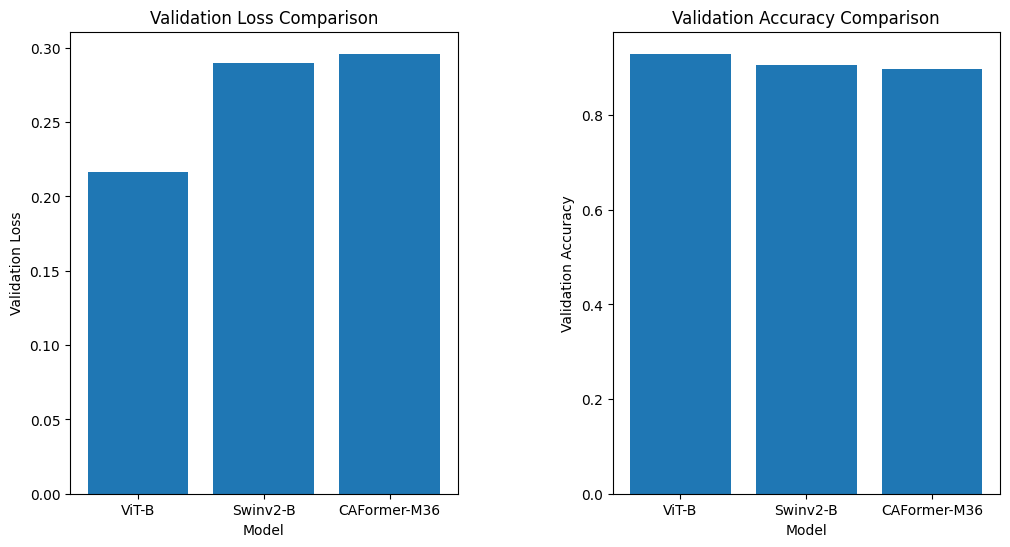

In [33]:
compare_results(results_infos)

In [34]:
def plot_histories(results_infos):

    fig, axs = plt.subplots(3, 2, figsize=(14, 24))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for instance in range(3):
        results_info = results_infos[instance]

        model_name = results_info['model_name']
        train_losses = results_info['train_loss_history']
        val_losses = results_info['val_loss_history']
        train_accs = results_info['train_accuracy_history']
        val_accs = results_info['val_accuracy_history']

        ax1, ax2 = axs[instance]
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title(f'{model_name} - Loss')

        ax2.plot(train_accs, label='Train Accuracy')
        ax2.plot(val_accs, label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title(f'{model_name} - Accuracy')

    plt.show()

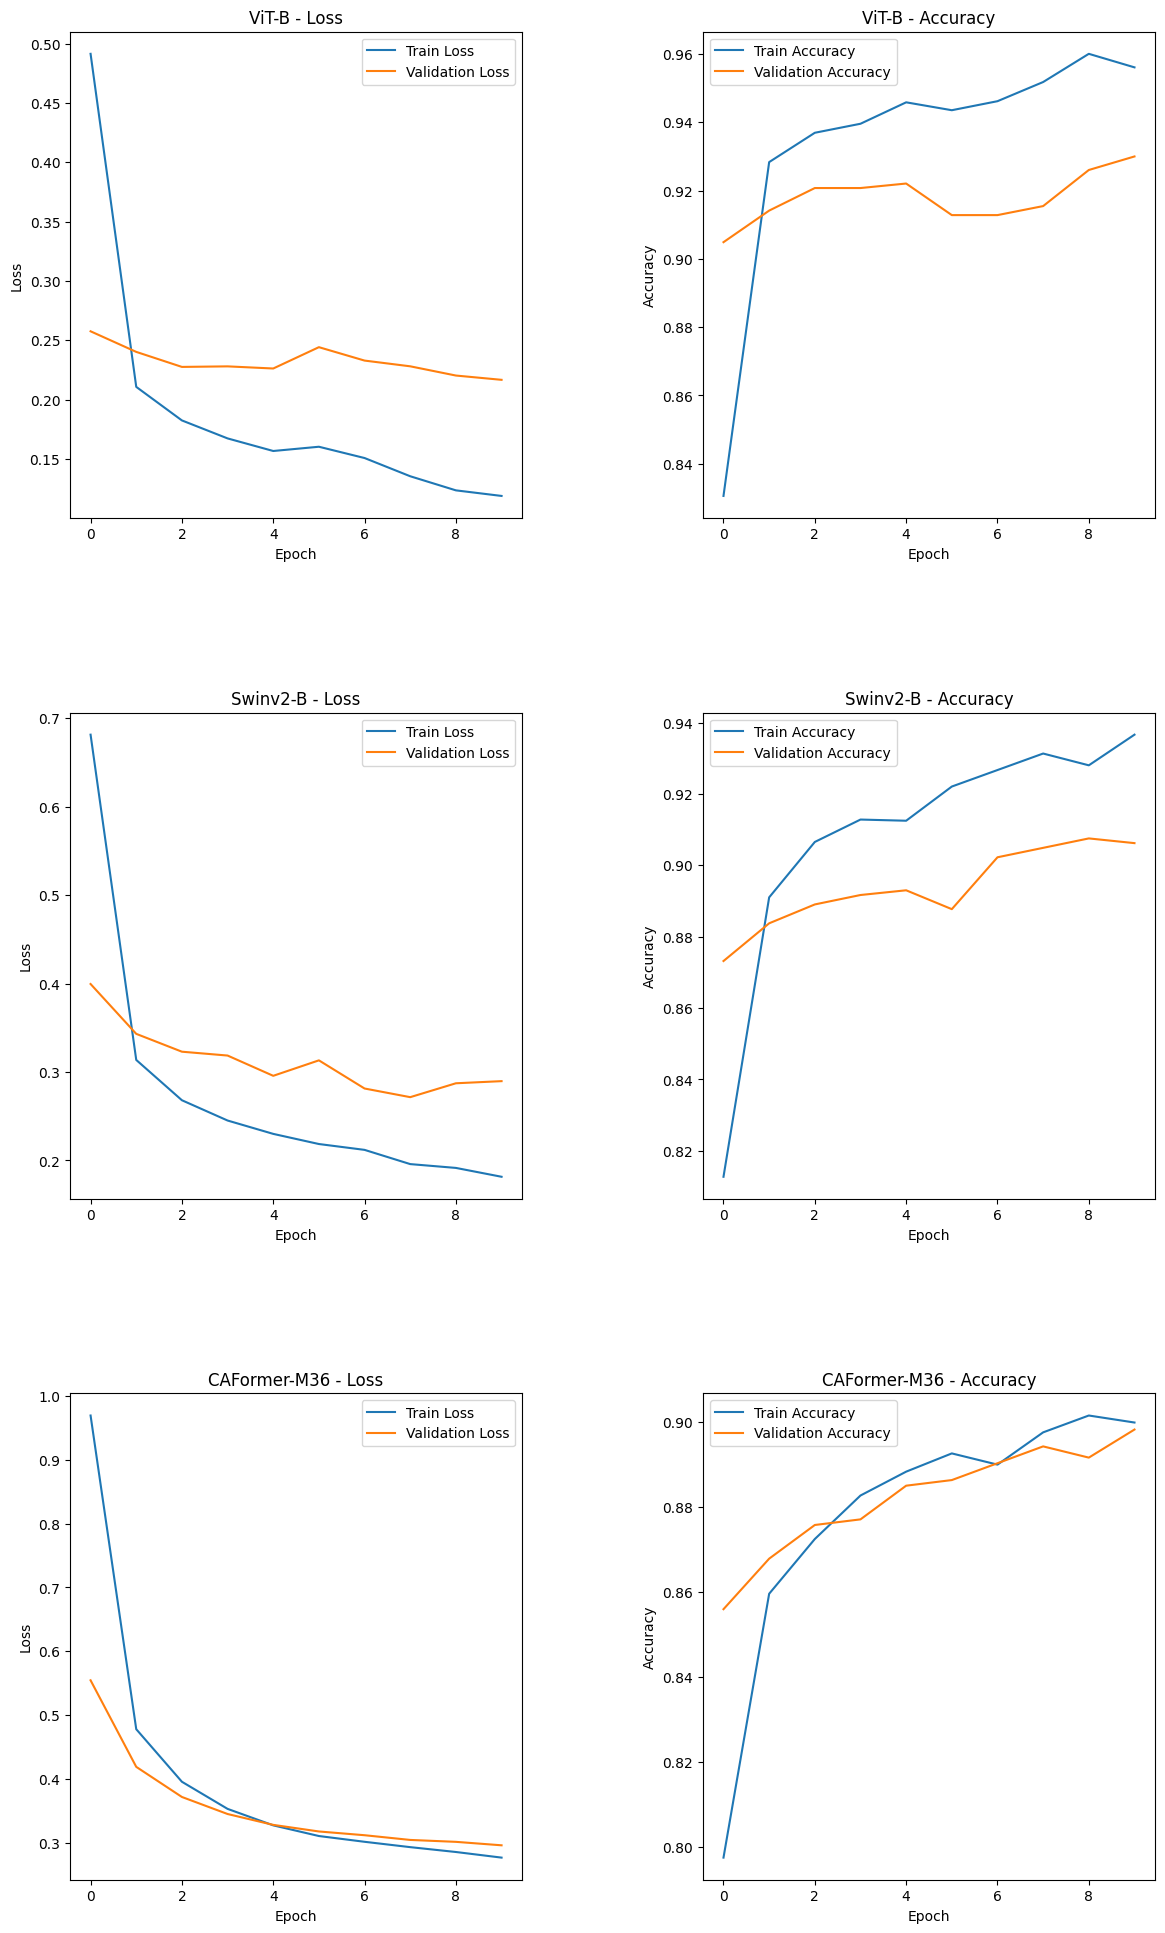

In [35]:
plot_histories(results_infos)

In [36]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

## Voting

In [37]:
def weighted_voting(logits_list, weights):
    weighted_sum_logits = torch.zeros_like(logits_list[0])

    for logits, weight in zip(logits_list, weights):
        weighted_sum_logits += logits * weight

    final_probabilities = F.softmax(weighted_sum_logits, dim=1)
    final_predictions = torch.argmax(final_probabilities, dim=1)

    return final_predictions, final_probabilities

0.9339498018494056


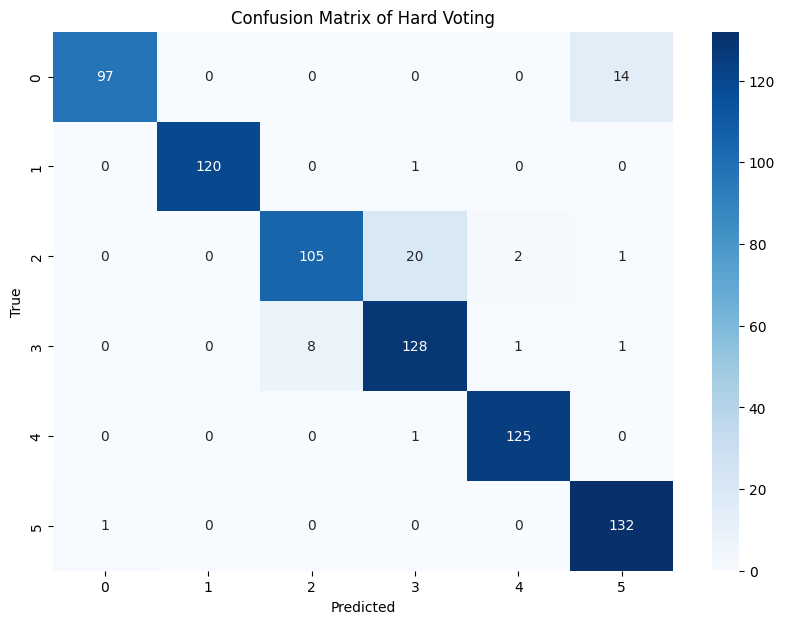

0.9352708058124174


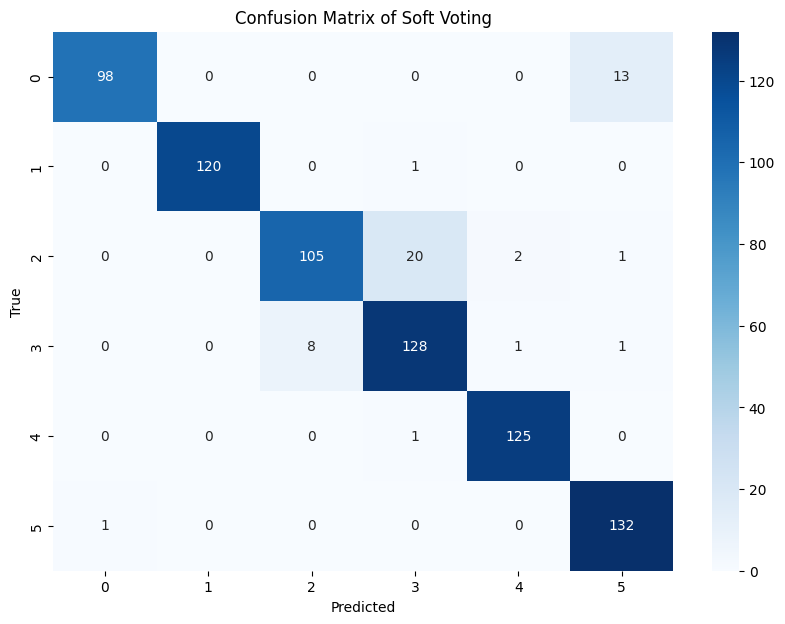

In [46]:
from sklearn.metrics import accuracy_score

val_logits_list = []
val_acc_list = []
train_set = pd.read_csv(train_path)
_, val_set = train_test_split(train_set, test_size=0.2, random_state=42, stratify=train_set.label)

for instance in range(3):
    val_logits_list.append(results_infos[instance]['val_logits'])
    val_acc_list.append(results_infos[instance]['val_accuracy_history'][-1])

# Val set에 대하여 voting 진행
for voting_method in ['Hard', 'Soft']:
    if voting_method == 'Hard':
        weights = [1 for _ in val_acc_list]
    elif voting_method == 'Soft':
        weights = [va*2 / sum(val_acc_list) for va in val_acc_list]

    val_predictions, _ = weighted_voting(val_logits_list, weights)

    print(accuracy_score(val_set.label, val_predictions))
    plot_confusion_matrix(val_set.label, val_predictions, f'Confusion Matrix of {voting_method} Voting')

In [47]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.9 MB/s eta 0:00:00


[I 2024-06-07 08:59:44,302] A new study created in memory with name: no-name-a9c58ca4-b47a-4751-9d6b-a0f2e792163a
[I 2024-06-07 08:59:44,311] Trial 0 finished with value: 0.9379128137384413 and parameters: {'weight1': 0.2474947812658722, 'weight2': 0.05928025402131454, 'weight3': 0.14797479325131702}. Best is trial 0 with value: 0.9379128137384413.
[I 2024-06-07 08:59:44,314] Trial 1 finished with value: 0.9128137384412153 and parameters: {'weight1': 0.010479433022739237, 'weight2': 0.2972799818940338, 'weight3': 0.5342293483473962}. Best is trial 0 with value: 0.9379128137384413.
[I 2024-06-07 08:59:44,317] Trial 2 finished with value: 0.9365918097754293 and parameters: {'weight1': 0.9969508808911908, 'weight2': 0.23570623701760574, 'weight3': 0.7538766798771045}. Best is trial 0 with value: 0.9379128137384413.
[I 2024-06-07 08:59:44,321] Trial 3 finished with value: 0.9299867899603699 and parameters: {'weight1': 0.5547293199994249, 'weight2': 0.726470870524754, 'weight3': 0.692840488

Best weights:  {'weight1': 0.8478005833828788, 'weight2': 0.5838150136033946, 'weight3': 0.15393381246732862}
Best accuracy:  0.9418758256274768
Accuracy with best weights:  0.9418758256274768


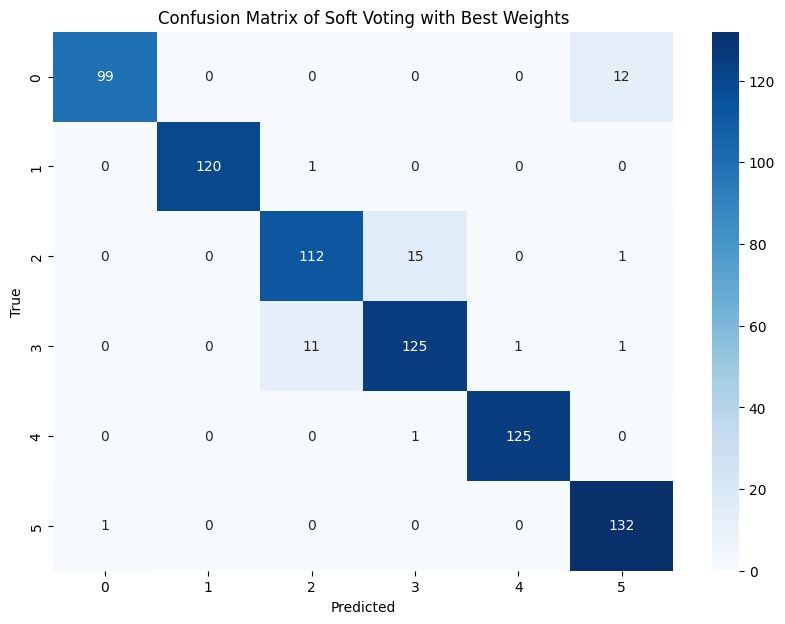

In [52]:
import optuna

seed_everything()

def objective(trial):
    # Generate three weights for soft voting
    weight1 = trial.suggest_float('weight1', 0.0, 1.0)
    weight2 = trial.suggest_float('weight2', 0.0, 1.0)
    weight3 = trial.suggest_float('weight3', 0.0, 1.0)

    # Normalize weights
    total_weight = weight1 + weight2 + weight3
    weights = [weight1 / total_weight, weight2 / total_weight, weight3 / total_weight]

    # Perform weighted voting
    val_predictions, _ = weighted_voting(val_logits_list, weights)

    # Calculate accuracy
    accuracy = accuracy_score(val_set.label, val_predictions)

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

print("Best weights: ", study.best_params)
print("Best accuracy: ", study.best_value)

# Plotting the confusion matrix for the best weights
best_weights = [study.best_params['weight1'], study.best_params['weight2'], study.best_params['weight3']]
total_weight = sum(best_weights)
normalized_best_weights = [w / total_weight for w in best_weights]

val_predictions, _ = weighted_voting(val_logits_list, normalized_best_weights)
print("Accuracy with best weights: ", accuracy_score(val_set.label, val_predictions))
plot_confusion_matrix(val_set.label, val_predictions, 'Confusion Matrix of Soft Voting with Best Weights')

In [53]:
from sklearn.metrics import accuracy_score

test_logits_list = []
test_set = pd.read_csv(test_path)

for instance in range(3):
    test_logits_list.append(results_infos[instance]['test_logits'])

weights = [0.848, 0.584, 0.154]

test_predictions, _ = weighted_voting(test_logits_list, weights)

test_set['label'] = test_predictions
test_set[['image_name', 'label']].to_csv('/content/drive/MyDrive/ML_Project3/submission.csv', index=False)